In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [154]:
def fftwn(n):
    ##wavenumber sequence for fft results in 1 dimension
    nup = int(np.ceil((n+1)/2))
    if n%2 == 0:
        wn = np.concatenate((np.arange(0, nup), np.arange(2-nup, 0)))
    else:
        wn = np.concatenate((np.arange(0, nup), np.arange(1-nup, 0)))
    return wn

def get_wn(fld):
    ##generate meshgrid wavenumber for input field
    ## the last two dimensions are horizontal (y, x)
    ny, nx = fld.shape[-2:]
    wnx = np.zeros(fld.shape)
    wny = np.zeros(fld.shape)
    for i in fftwn(fld.shape[-1]):
        wnx[..., i] = i
    for j in fftwn(fld.shape[-2]):
        wny[..., j, :] = j
    return wnx, wny


def random_field(fld, amp, sig):    
    kx, ky = get_wn(fld)
    k2d = np.sqrt(kx**2 + ky**2)
    
    ##random phase from white noise
    ph = np.fft.fft2(np.random.normal(0, 1, fld.shape))

    ##assemble random field given amplitude from power spectrum, and random phase ph
    norm2 = np.sum(np.exp(-2. * k2d**2 / sig**2)) / (nx*ny)
    pwr_spec = lambda k: amp * np.exp(-k**2 / sig**2) / np.sqrt(norm2)

    field = np.real(np.fft.ifft2(pwr_spec(k2d) * ph))
    return field


In [55]:
##some spectral diagnostics
def pwrspec2d(fld):
    ##horizontal 2d power spectrum p(k2d), on a regular Cartesian grid
    ##for very large grid, the map factors will cause slight errors in grid spacings
    ##but okay for relatively small grids. Of course for global analysis one shall use
    ##the spherical harmonics instead
    ##  input fld[..., ny, nx]
    ##  return wn[0:nup], pwr[..., 0:nup], nup is the max wavenumber given ny,nx
    nx = fld.shape[-1]
    ny = fld.shape[0]
    kx, ky = get_wn(fld)
    nupx = kx.max()
    nupy = ky.max()
    nup = int(max(nupx, nupy))

    ##2d total wavenumber
    k2d = np.sqrt((kx*(nup/nupx))**2 + (ky*(nup/nupy))**2)

    ##2d fft of fld, convert to power (variance)
    P = (np.abs(np.fft.fft2(fld))/ny/nx)**2

    ##sum all kx,ky points with same k2d
    wn = np.arange(0., nup)
    pwr = np.zeros(fld.shape[:-2] + (nup,))
    for w in range(nup):
        pwr[..., w] = np.mean(P[np.where(np.ceil(k2d)==w)])
        ###TODO mean, or sum?
    return wn, pwr

In [163]:
def func2d(sig):
    length = 1
    ny, nx = fld.shape
    kx, ky = get_wn(fld)
#    kx_ = 2*np.pi*kx / (nx)
#    ky_ = 2*np.pi*ky / (ny)
    sum1 = np.sum(np.exp(-2.0*(kx**2 + ky**2)/sig**2) * np.cos(2*np.pi*kx/nx*length))
    sum2 = np.sum(np.exp(-2.0*(kx**2 + ky**2)/sig**2))
    return sum1/sum2 - np.exp(-1)

In [164]:
sigs = np.arange(0.05, 100, 0.1)
funcs = np.zeros(sigs.size)
for i in range(sigs.size):
    funcs[i] = func2d(sigs[i])


In [165]:
sig0 = 1

# Find the root(s) using fsolve
sig1 = np.abs(fsolve(func2d, sig0)[0])

##special case when there is no solution?


In [166]:
sig1

95.17858210459327

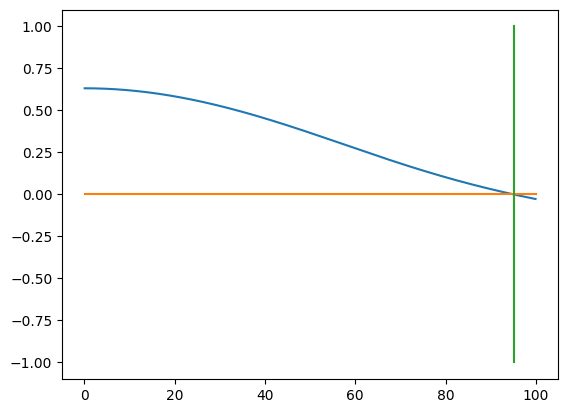

In [167]:
plt.plot(sigs, funcs)
plt.plot(sigs, np.zeros(sigs.size))
plt.plot([sig1, sig1], [-1, 1])

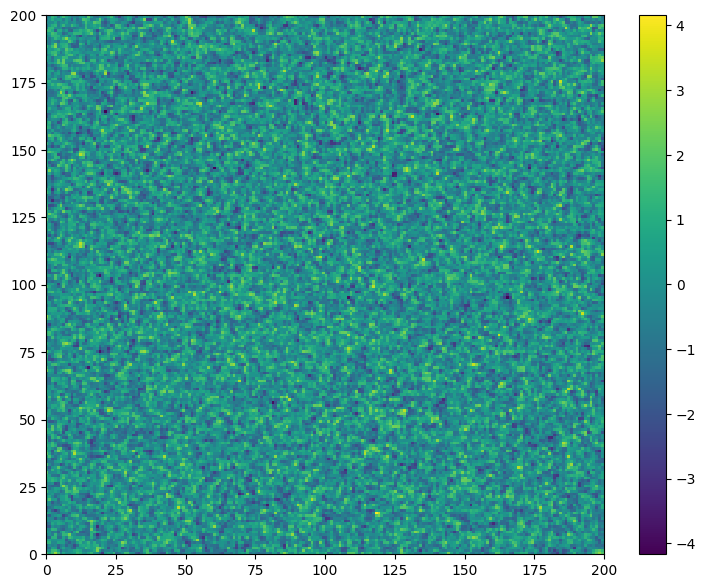

In [168]:
nx = 200
ny = 200
fld = np.zeros((ny, nx))

#amp = 1   ##controls the amplitude of the noise
#sig = 3  ##controls the spatial scale of the noise

np.random.seed(0)
noise = random_field(fld, 1, sig1)

fig, ax = plt.subplots(1, 1, figsize=(9,7))
im = ax.pcolor(noise)
plt.colorbar(im)

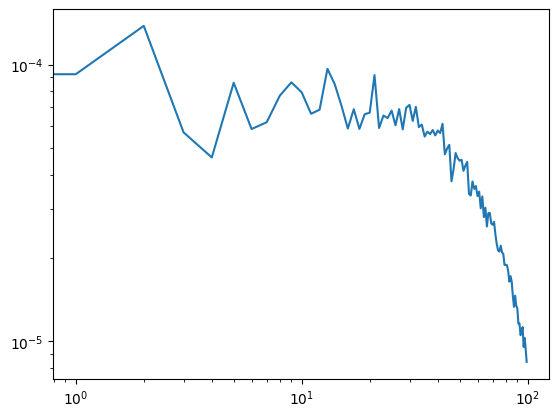

In [169]:
wn, pwr = pwrspec2d(noise)

plt.loglog(wn, pwr)
#plt.ylim(1e-10, 1e2)

In [132]:
np.std(noise)

0.9889278027974722

In [ ]:
##length scale

##draw many samples
